##DID-Analysis-on-TV-Mail-Campaign##
This is a small project to simulate TV&Mail campaign process and using Difference in Difference method to measure how mail is affecting our customer acqusition.

In [1]:
#import all the modlues that is required
import pandas as pd
import numpy as np
import re
import seaborn
seaborn.set()
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline 
style.use('ggplot')
import faker
from faker import Faker
from random import sample
from datetime import datetime, timedelta
from datetime import date
import datetime
import random
from random import randint
from collections import OrderedDict

####Generate Campaign info table to record the campign info for future analysis
#####Campaign_info  
Campaign_Type: string  
StartDate: date  
EndDate: date  
Price: decimal  
Units: int  
Borough: string  

In [2]:
###Factors###
n = 1000 #Total Sample Size
m = 500  #Treatment Sample Size
Mail_StartDate, Mail_EndaDate, Mail_price, Mail_Unit,Mail_Bor = '2018-02-01','2018-03-01', 10,m,'UpperEast&UpperWest'

###Create Campign info table to record all the campagin details###
data = np.array([['Campaign_Type','StartDate','EndDate','Price','Units','Borough'],
                ['TV','2018-01-01','2018-04-01', 5,n,'Manhattan'],
                ['Mail',Mail_StartDate, Mail_EndaDate, Mail_price, m, Mail_Bor],
                ['Radio','2018-03-01','2018-04-01', 12,300,'UpperEast']]) 

campign_info = pd.DataFrame(data = data[1:,:],
                            columns = data[0,:])
campign_info.head()

,Campaign_Type,StartDate,EndDate,Price,Units,Borough
0,TV,2018-01-01,2018-04-01,5,1000,Manhattan
1,Mail,2018-02-01,2018-03-01,10,500,UpperEast&UpperWest
2,Radio,2018-03-01,2018-04-01,12,300,UpperEast


####Create Resident Info, when they are affected by campagin, GrubHub enrollment status and enrollment Start date

In [3]:
class Resident:
 def __init__(self): 
    self.fake = Faker()
    self.FirstName = self.fake.first_name()
    self.LastName = self.fake.last_name()
    self.Address = self.fake.street_name()
    self.PhoneNumber = self.fake.phone_number()
 
resident_info = pd.DataFrame(columns =['FirstName','LastName','Address','Borough','PhoneNumer','Enrollment',
                                       'Enrollment_StartDate','TV_Target','Mail_Target','Train_Target'])
for i in range(n):
        resident = Resident()
        resident_info.loc[i,:] = [resident.FirstName,resident.LastName,resident.Address,'Manhattan',resident.PhoneNumber,
                                   False, None, False, False, False]
        resident_info.loc[i,'TV_Target'] = True
rindex =  np.array(sample(range(len(resident_info)), m))
resident_info.loc[rindex,'Mail_Target'] = True
resident_info.head()

,FirstName,LastName,Address,Borough,PhoneNumer,Enrollment,Enrollment_StartDate,TV_Target,Mail_Target,Train_Target
0,Rhonda,Grant,Davis Spring,Manhattan,154-838-6463,False,None,True,False,False
1,Jason,Coleman,Melissa Circles,Manhattan,608.647.0160,False,None,True,False,False
2,Erik,Chambers,Evans Path,Manhattan,(134)779-1474x8146,False,None,True,True,False
3,Ivan,Leach,Bryan Views,Manhattan,217-915-8967x9617,False,None,True,False,False
4,William,Fitzpatrick,Samuel Brook,Manhattan,09895618318,False,None,True,False,False


####Simulate the TV Campign and Mail Campign
#####Assumption:
1. The number customers coming from TV is having a linear relation with the # of days since the campaign started:
   number of Customers(TV) = 2Days + 100 + ∆
2. There is no cannibalization or correlation between two campaign
3. Since we did no world-of-mouth effect on two campaign, customers are purely attracted by campaign

In [4]:
#Time range: 01/01/2018 to 03/01/2018
datelist = pd.date_range('2018-01-01', '2018-03-01').tolist() 
cus_old = 0
Customer_status = []
for date_now in datelist:
    ###### Simulate the Customer Growth from TV Campagin
    days = str(date_now - datetime.datetime.strptime('2018-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")) 
    TV_Customer  = 2 * int(days.split(" ")[0]) + 100 + randint(-1,1) 
    TV_cus_new = TV_Customer - cus_old
    ##group 1 where We have both TV Campign but not Mail Campign
    sample_list = []
    for i in resident_info[(resident_info['Enrollment'] == False) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == False)].index: # only find those who has nto being affected yet
        sample_list.append(i)
        
    for j in random.sample(sample_list,TV_cus_new):
        resident_info.loc[j,"Enrollment"] = True
        resident_info.loc[j,"Enrollment_StartDate"] = date_now
        
    ##group 2 where We have both TV Campign and Mail Campign
    sample_list = []
    for i in resident_info[(resident_info['Enrollment'] == False) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == True)].index:
        sample_list.append(i)
    for j in random.sample(sample_list,TV_cus_new):
        resident_info.loc[j,"Enrollment"] = True
        resident_info.loc[j,"Enrollment_StartDate"] = date_now
        
    ####Simulate the Customer Growth from Mail Campign
    if date_now >= datetime.datetime.strptime('2018-02-01 00:00:00', "%Y-%m-%d %H:%M:%S"):
        Mail_New_Customer = randint(0,5) 
        sample_list = []
        for i in resident_info[(resident_info['Enrollment'] == False) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == True)].index:
            sample_list.append(i)
        for j in random.sample(sample_list,Mail_New_Customer):
            resident_info.loc[j,"Enrollment"] = True
            resident_info.loc[j,"Enrollment_StartDate"] = date_now
    
    #print(len(sample_list))
    cus_old = TV_Customer
resident_info.head() #how the resident_info will look like after the two-month campaign

,FirstName,LastName,Address,Borough,PhoneNumer,Enrollment,Enrollment_StartDate,TV_Target,Mail_Target,Train_Target
0,Rhonda,Grant,Davis Spring,Manhattan,154-838-6463,True,2018-01-01 00:00:00,True,False,False
1,Jason,Coleman,Melissa Circles,Manhattan,608.647.0160,True,2018-01-01 00:00:00,True,False,False
2,Erik,Chambers,Evans Path,Manhattan,(134)779-1474x8146,False,None,True,True,False
3,Ivan,Leach,Bryan Views,Manhattan,217-915-8967x9617,True,2018-01-01 00:00:00,True,False,False
4,William,Fitzpatrick,Samuel Brook,Manhattan,09895618318,False,None,True,False,False


####Calculate the three types of Differences
D1: New customers coming only be affected by TV campaign  
D2: New customers coming only be affected by TV and Mail campaign  
D3: Estimated customers coming only be affected by Mail campaign  
D3 = D2 - D1

In [5]:
#Calculate the Cumulative Customer Counts for every day
Group1 = resident_info['Enrollment_StartDate'][(resident_info['Enrollment'] == True) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == False)].groupby(resident_info['Enrollment_StartDate']).count()

Group2 = resident_info['Enrollment_StartDate'][(resident_info['Enrollment'] == True) & (resident_info['TV_Target'] == True) 
                           & (resident_info['Mail_Target'] == True)].groupby(resident_info['Enrollment_StartDate']).count()
group1_list = []
group2_list = []
standard1 = []
standard2 = []
summ = 0
j = 0
for i in Group1.index:
    if summ == 0:
        group1_list.append([i, int(Group1[i])])
    else:
        group1_list.append([i, int(Group1[i]) + summ])
    summ = int(Group1[i]) + summ

D1 = summ
summ = 0
start = 0
for i in Group2.index:
    standard1.append([i, int(Group2[0])])
    if i == datetime.datetime.strptime('2018-02-01 00:00:00', "%Y-%m-%d %H:%M:%S"):
        start = summ
    if start != 0:
        standard2.append([i, start])
    if summ == 0:
        group2_list.append([i, int(Group2[i])])
    else:
        group2_list.append([i, int(Group2[i]) + summ])
    summ = int(Group2[i]) + summ
D2 = summ
D3 = D2 - D1

###Visualize the whole simulation process 

D1 = 217 ; D2 = 296 
D3 = D2 - D1 = 79 (No. New Customers from Mail Campaign)


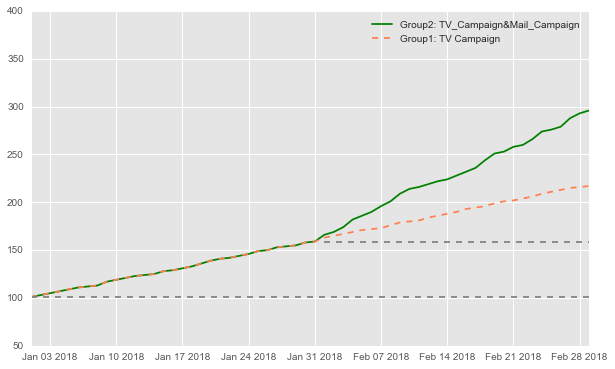

In [29]:
print("D1 = " + str(D1),"; D2 = "+str(D2), "\nD3 = D2 - D1 = " + str(D2 - D1) + " (No. New Customers from Mail Campaign)")
plt.plot([i[0] for i in group2_list], [i[1] for i in group2_list],'g', label='Group2: TV_Campaign&Mail_Campaign')
plt.plot([i[0] for i in group1_list], [i[1] for i in group1_list], 'coral',linestyle='dashed', label='Group1: TV Campaign')
plt.plot([i[0] for i in standard1], [i[1] for i in standard1], color='gray', linestyle='dashed')
plt.plot([i[0] for i in standard2], [i[1] for i in standard2], color='gray', linestyle='dashed')
plt.legend()
plt.ylim((50,400))
plt.rcParams['figure.figsize']=[10,10]
plt.show()